In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from lightkurve import search_lightcurvefile
from requests.exceptions import HTTPError
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
from astropy.timeseries import LombScargle
from photutils import CircularAperture, aperture_photometry
from scipy.ndimage import gaussian_filter1d

import astropy.units as u

m67table = Table.read('../data/Gonzalez2016.vot')

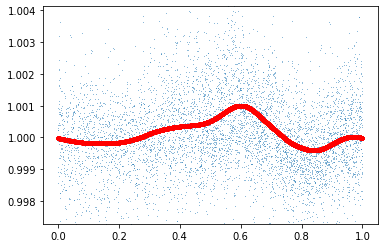

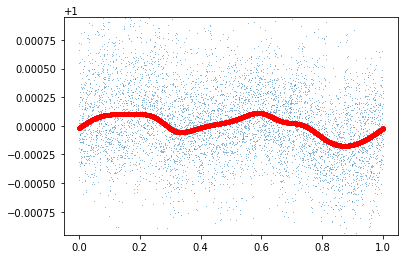

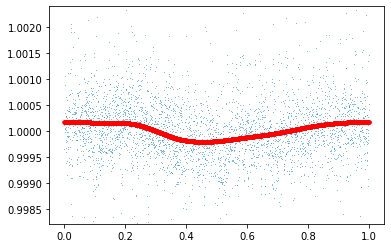

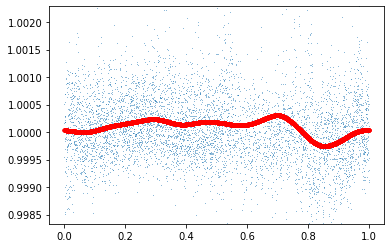

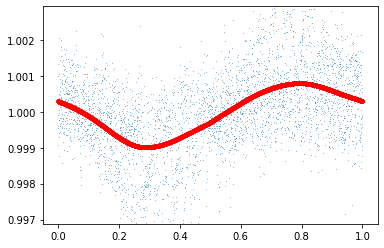

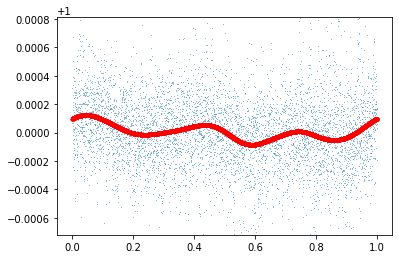

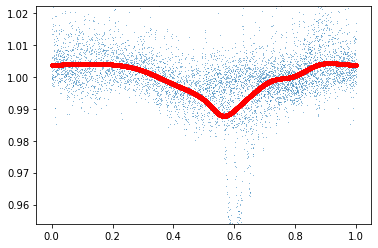

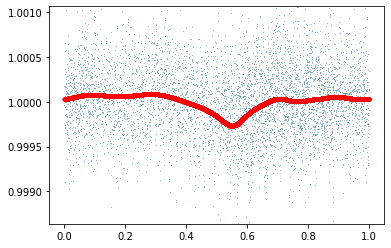

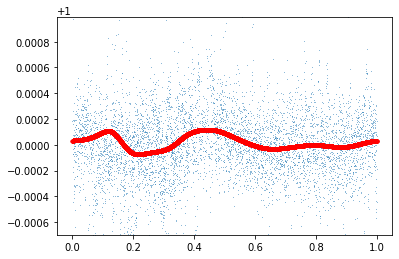

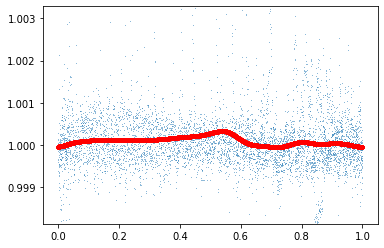

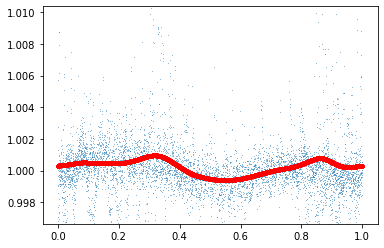

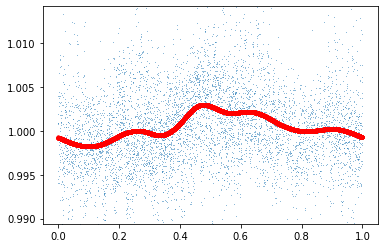

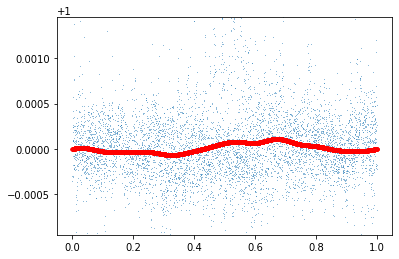

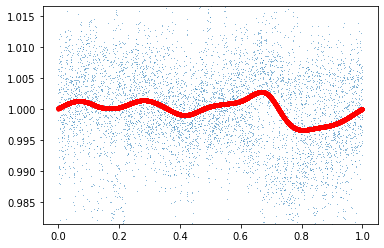

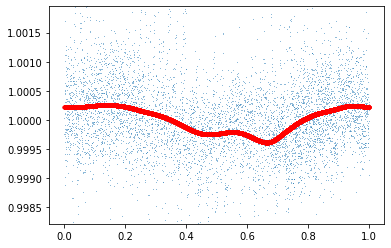

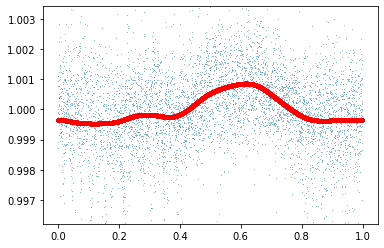

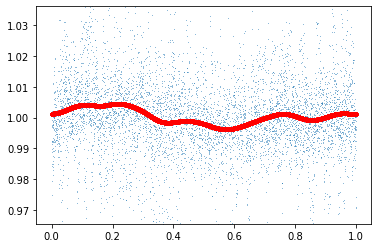

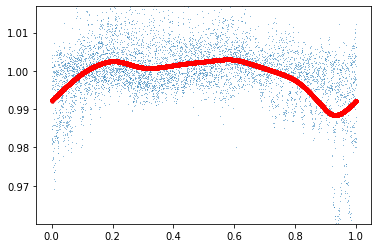

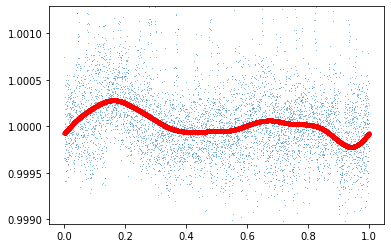

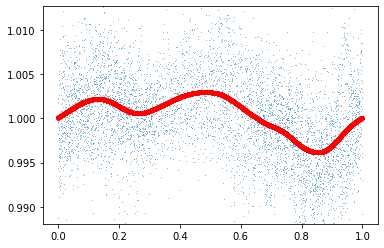

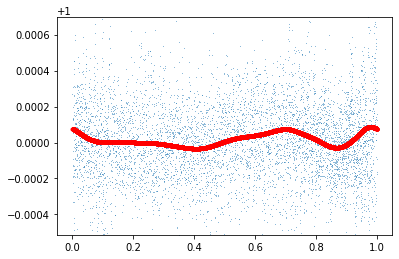

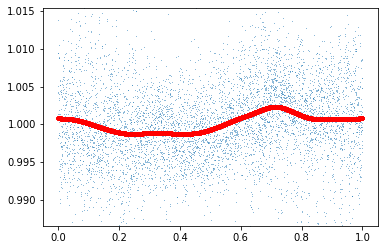

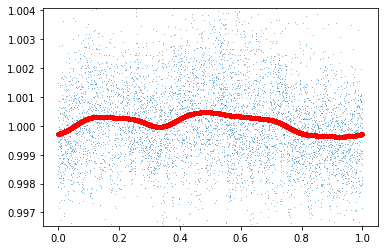

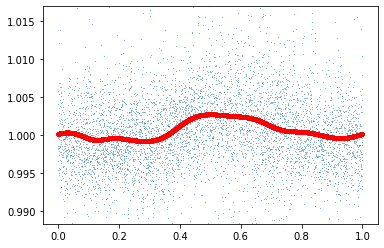

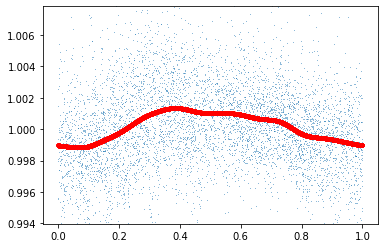

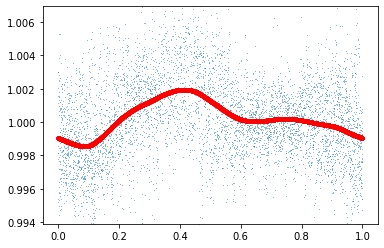

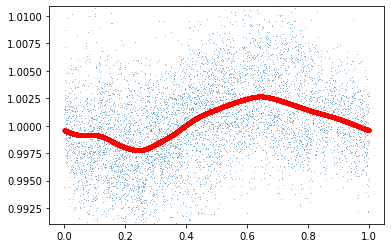

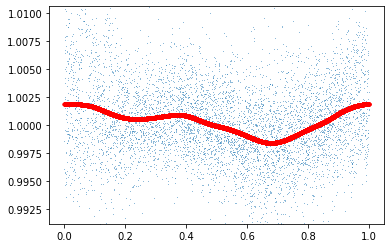

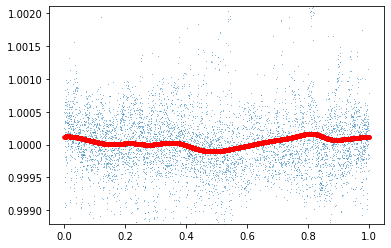

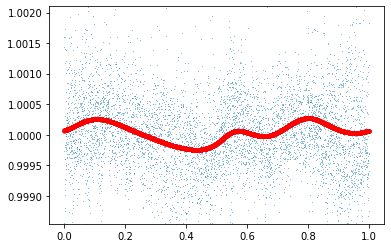

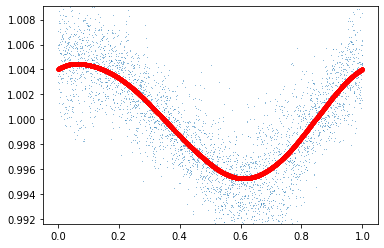

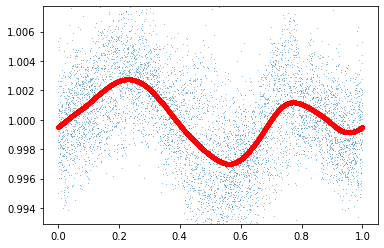

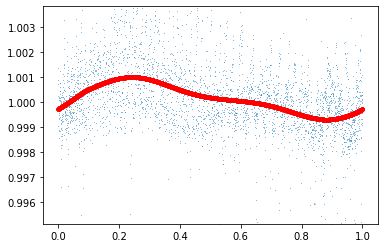

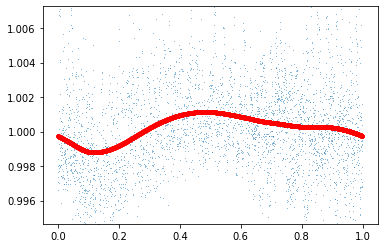

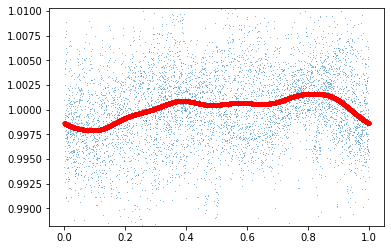

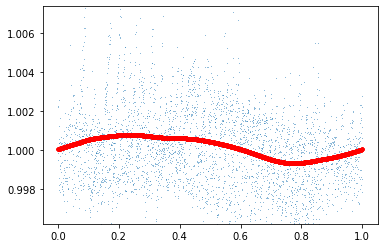

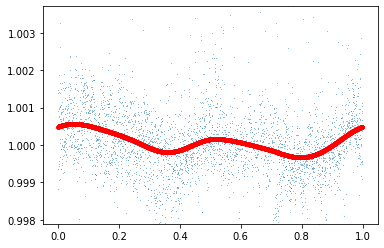

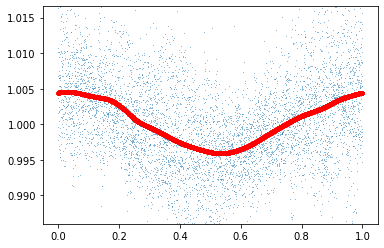

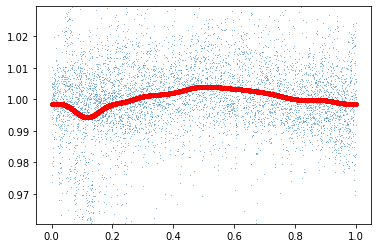

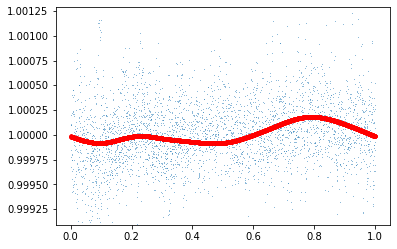

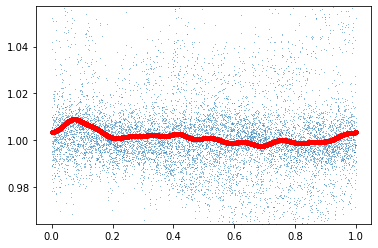

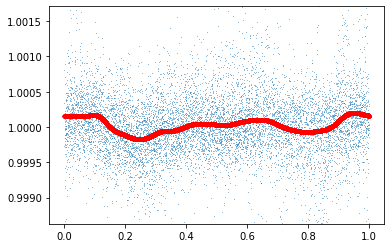

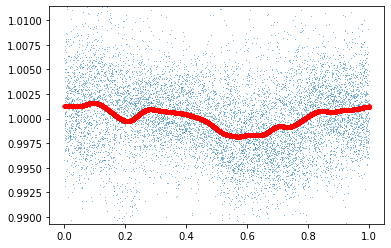

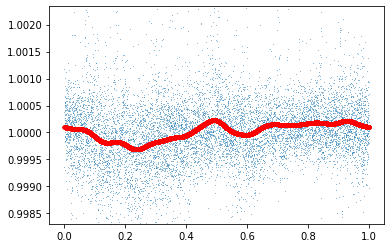

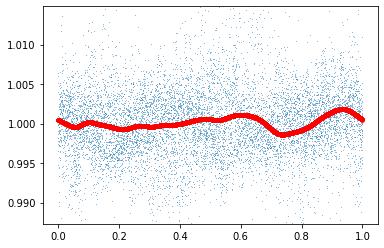

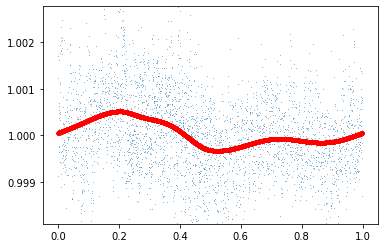

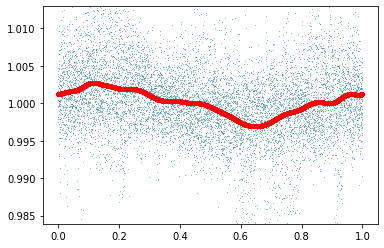

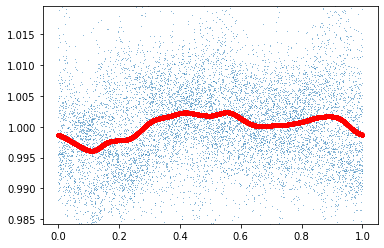

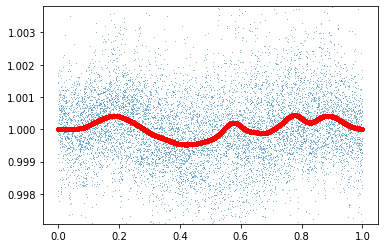

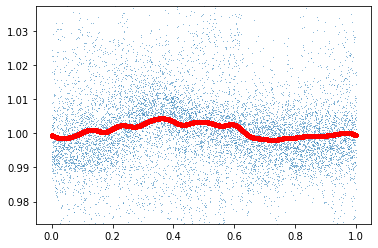

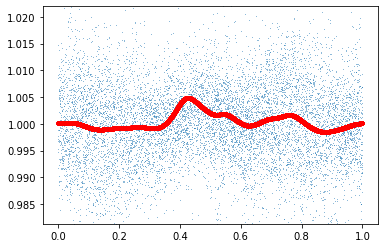

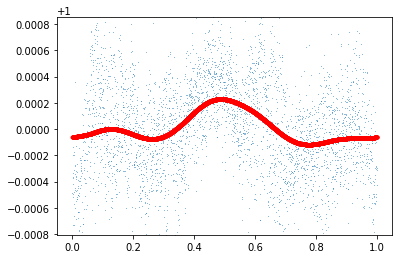

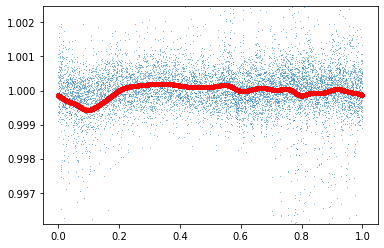

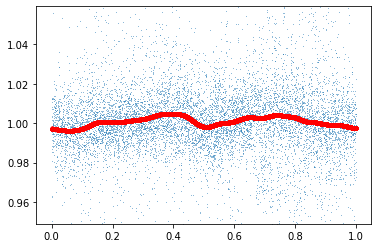

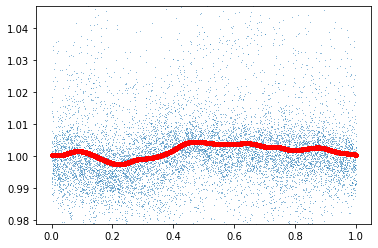

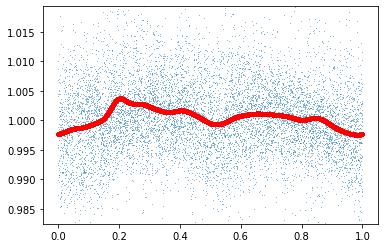

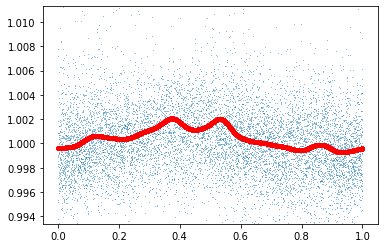

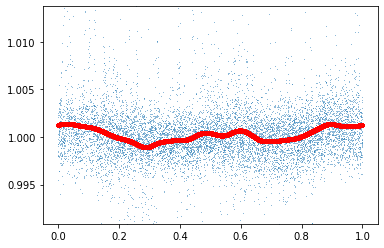

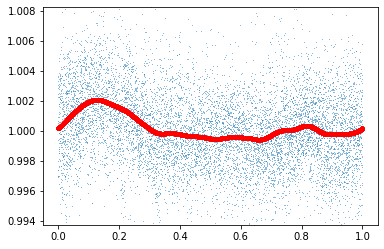

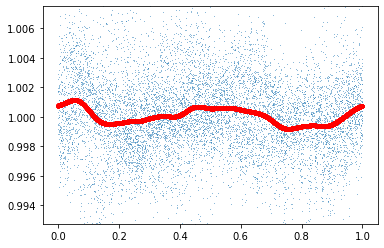

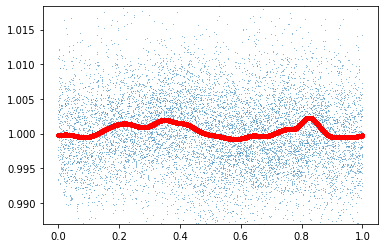

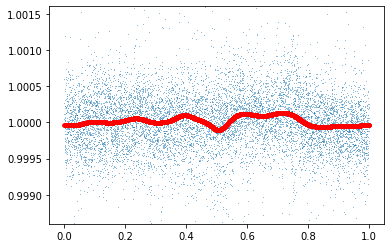

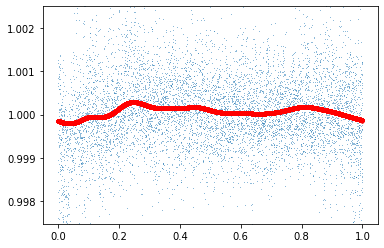

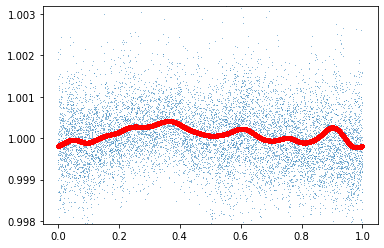

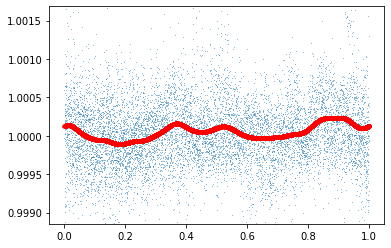

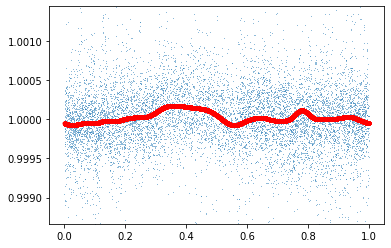

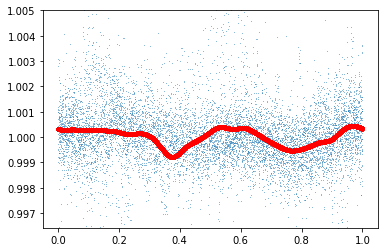

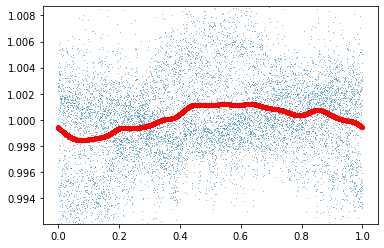

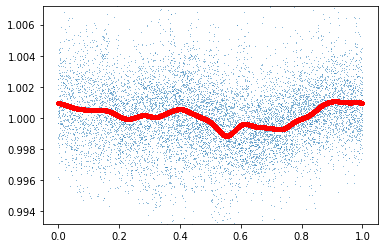

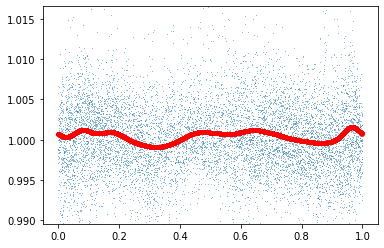

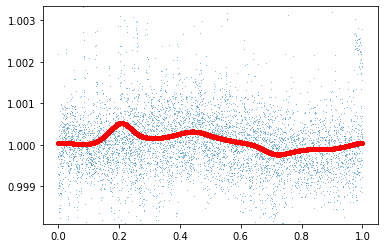

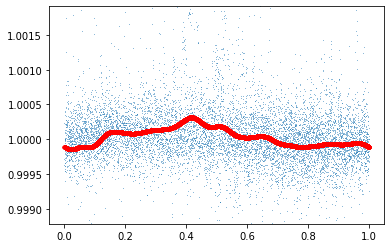

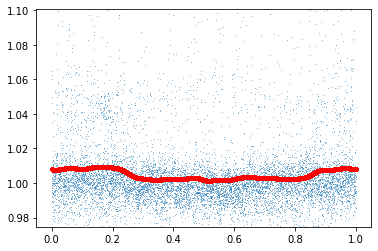

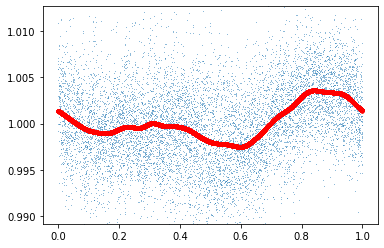

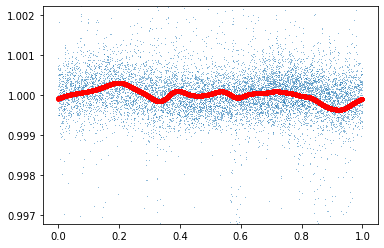

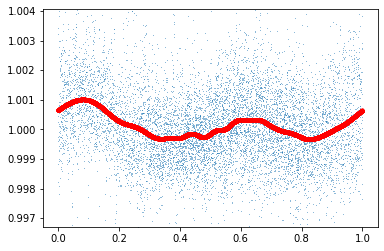

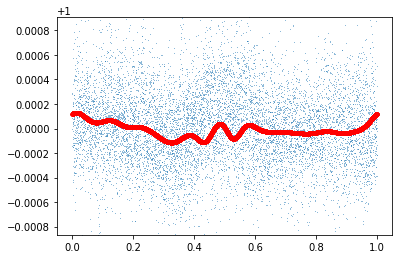

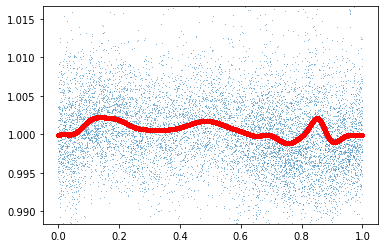

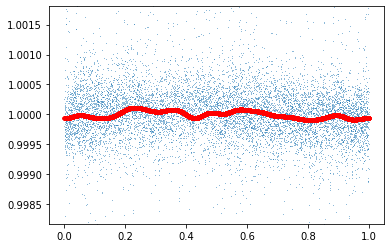

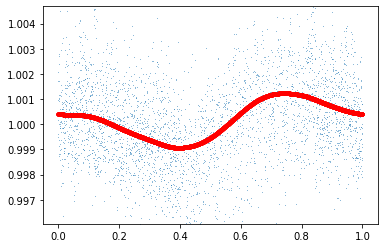

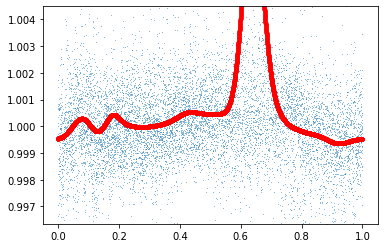

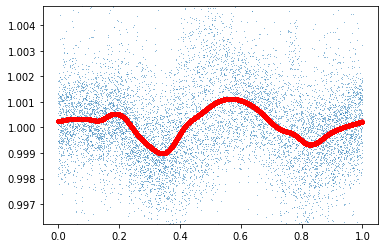

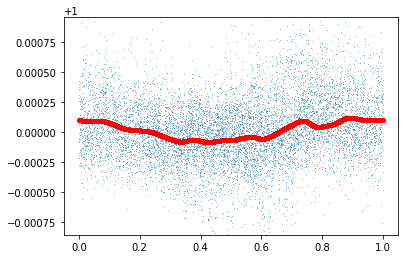

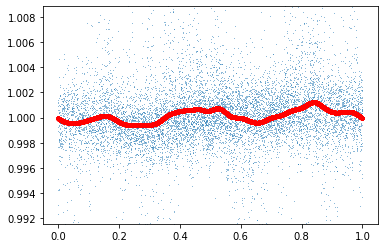

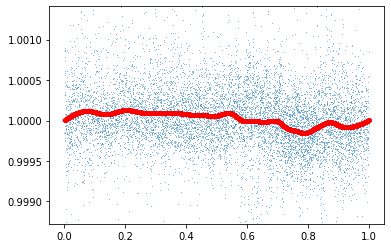

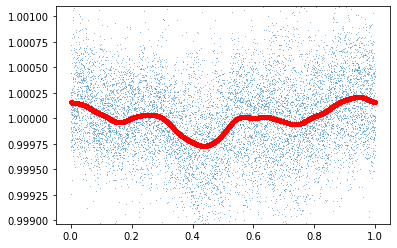

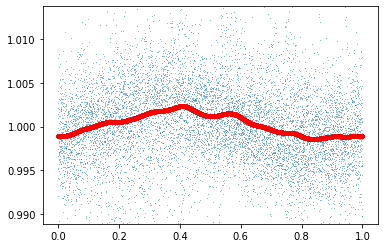

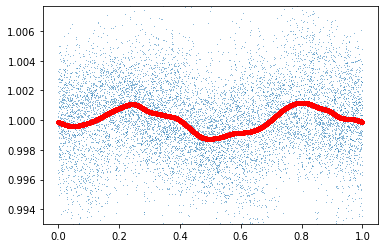

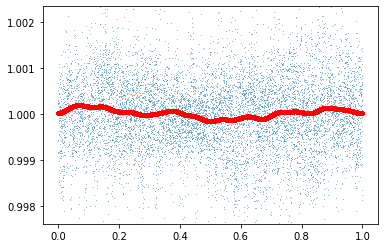

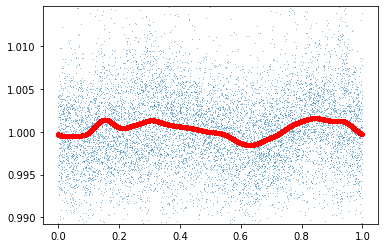

In [4]:
m67_smamps = []

m67_periods = m67table['Per'].data.data[m67table['B-V'] < 1.40]

for target, prot in zip(m67table['EPIC'][m67table['B-V'] < 1.40], m67_periods):
    try: 
        slcf = search_lightcurvefile("EPIC {0}".format(target), mission='K2')
        lc = slcf.download_all()
        pdcsap = lc.PDCSAP_FLUX.stitch()

        phases = (((pdcsap.time - 0) % prot) / prot)

        not_nan = ~np.isnan(pdcsap.flux)
        smoothed = gaussian_filter1d(pdcsap.flux[not_nan][np.argsort(phases[not_nan])], 250, mode='wrap')

        plt.plot(phases, pdcsap.flux, ',', alpha=0.5)
        plt.plot(phases[not_nan][np.argsort(phases[not_nan])], smoothed, '.r')
        plt.ylim(np.nanpercentile(pdcsap.flux, [1, 99]))
        plt.show()
        
        m67_smamps.append(smoothed.ptp())
        
    except ValueError:
        m67_smamps.append(np.nan)

In [5]:
np.save('data/m67_amps.npy', m67_smamps)
np.save('data/m67_pers.npy', m67_periods)